# Class-Conditional Synthesis with Latent Diffusion Models

Install all the requirements

In [2]:
#@title Installation
!git clone https://github.com/CompVis/latent-diffusion.git
!git clone https://github.com/CompVis/taming-transformers
!pip install -e ./taming-transformers
!pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops

# Load and modify the taming-transformers code
file_path = './taming-transformers/taming/data/utils.py'

with open(file_path, 'r') as file:
    lines = file.readlines()

with open(file_path, 'w') as file:
    for line in lines:
        if 'from torch._six import string_classes' in line:
            file.write('import collections.abc\n')
            file.write('string_classes = (str, bytes)\n')
        elif 'from torch.utils.data._utils.collate import np_str_obj_array_pattern, default_collate_err_msg_format' in line:
            file.write('from torch.utils.data._utils.collate import default_collate_err_msg_format\n')
            file.write('np_str_obj_array_pattern = (str, bytes, collections.abc.Sequence)\n')
        else:
            file.write(line)


import sys
sys.path.append(".")
sys.path.append('./taming-transformers')
from taming.models import vqgan

fatal: destination path 'latent-diffusion' already exists and is not an empty directory.
fatal: destination path 'taming-transformers' already exists and is not an empty directory.
Obtaining file:///content/taming-transformers
  Preparing metadata (setup.py) ... done
  Attempting uninstall: taming-transformers
    Found existing installation: taming-transformers 0.0.1
    Uninstalling taming-transformers-0.0.1:
      Successfully uninstalled taming-transformers-0.0.1
  Running setup.py develop for taming-transformers


Now, download the checkpoint (~1.7 GB). This will usually take 1-2 minutes.

In [3]:
#@title Download
%cd latent-diffusion/

!mkdir -p models/ldm/cin256-v2/
!wget -O models/ldm/cin256-v2/model.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/cin/model.ckpt

/content/latent-diffusion
--2024-06-02 10:09:36--  https://ommer-lab.com/files/latent-diffusion/nitro/cin/model.ckpt
Resolving ommer-lab.com (ommer-lab.com)... 141.84.41.65
Connecting to ommer-lab.com (ommer-lab.com)|141.84.41.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1827378153 (1.7G)
Saving to: ‘models/ldm/cin256-v2/model.ckpt’

models/ldm/cin256-v 100%[===================>]   1.70G  29.0MB/s    in 59s     

2024-06-02 10:10:35 (29.7 MB/s) - ‘models/ldm/cin256-v2/model.ckpt’ saved [1827378153/1827378153]



Let's also check what type of GPU we've got.

In [4]:
!nvidia-smi

Sun Jun  2 10:10:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Load it.

In [4]:
#@title loading utils
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt)#, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    model.eval()
    return model


def get_model():
    config = OmegaConf.load("configs/latent-diffusion/cin256-v2.yaml")
    model = load_model_from_config(config, "models/ldm/cin256-v2/model.ckpt")
    return model

In [2]:
!pip install git+https://github.com/openai/CLIP.git
# Step 1: 클론합니다
!git clone https://github.com/CompVis/latent-diffusion.git

# Step 2: 디렉토리로 이동합니다
%cd latent-diffusion

# Step 3: 필요한 의존성을 설치합니다
!pip install -e .


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-jz0ibfjn
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-jz0ibfjn
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
fatal: destination path 'latent-diffusion' already exists and is not an empty directory.
/content/latent-diffusion
Obtaining file:///content/latent-diffusion
  Preparing metadata (setup.py) ... done
  Running setup.py develop for latent-diffusion


In [6]:
!pip install kornia


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 38.3 MB/s eta 0:00:00


In [7]:
from ldm.models.diffusion.ddim import DDIMSampler

model = get_model()
sampler = DDIMSampler(model)

Loading model from models/ldm/cin256-v2/model.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


And go. Quality, sampling speed and diversity are best controlled via the `scale`, `ddim_steps` and `ddim_eta` variables. As a rule of thumb, higher values of `scale` produce better samples at the cost of a reduced output diversity. Furthermore, increasing `ddim_steps` generally also gives higher quality samples, but returns are diminishing for values > 250. Fast sampling (i e. low values of `ddim_steps`) while retaining good quality can be achieved by using `ddim_eta = 0.0`.

rendering 6 examples of class '25' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


rendering 6 examples of class '187' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


rendering 6 examples of class '448' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


rendering 6 examples of class '992' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


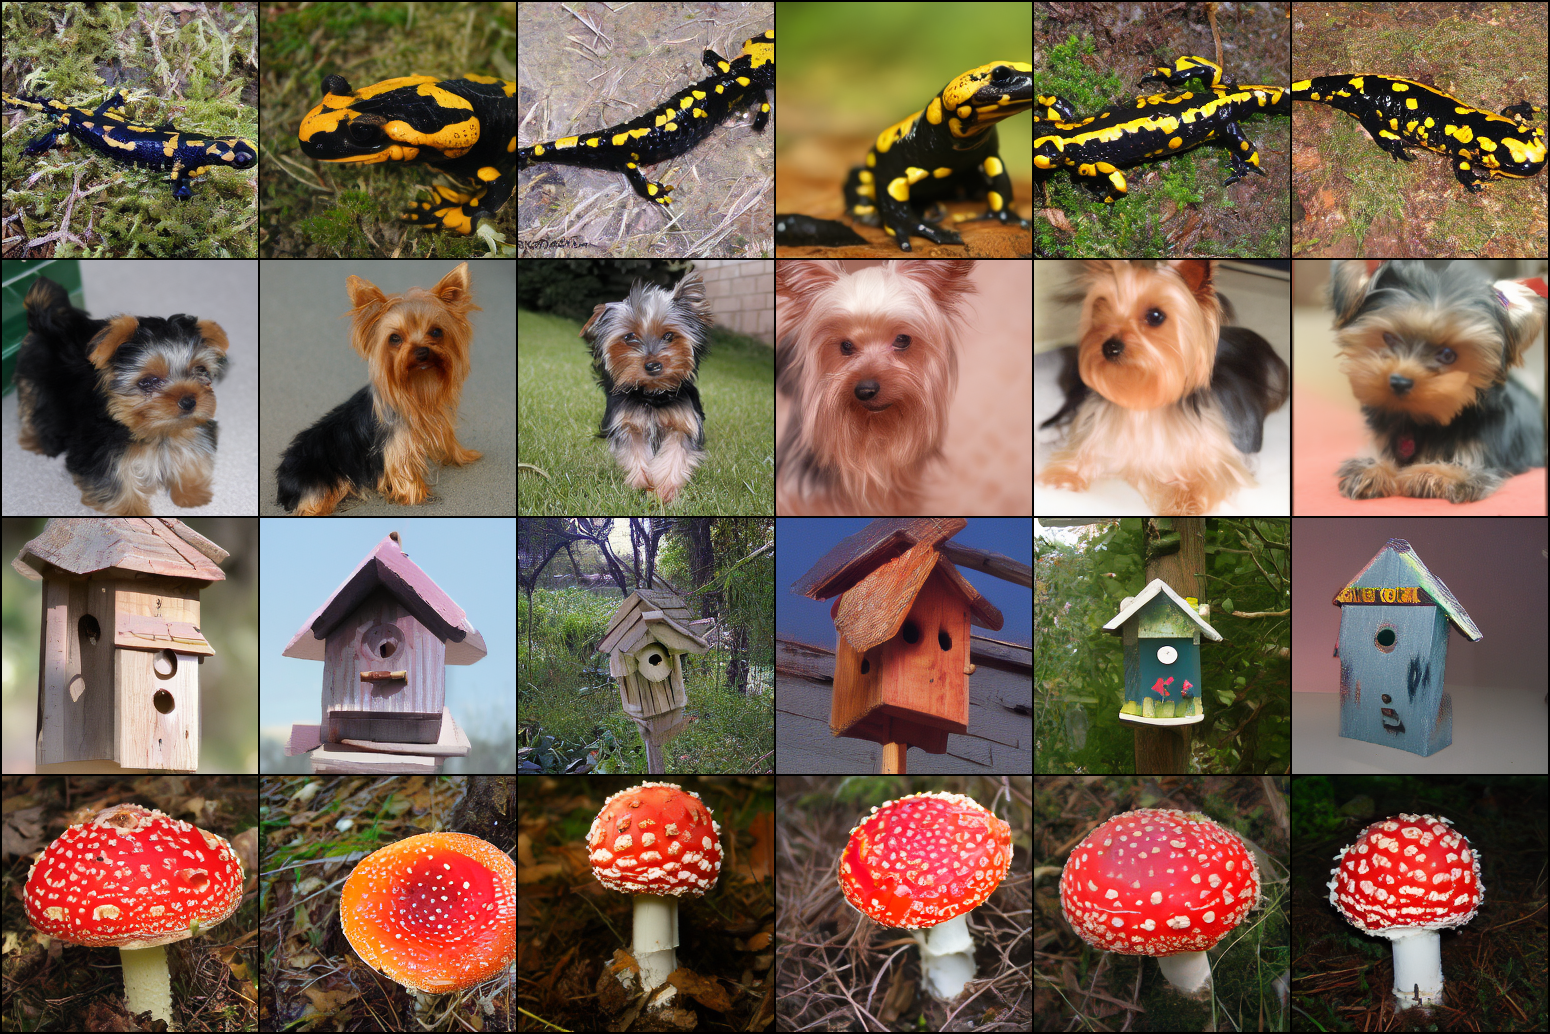

In [8]:
import numpy as np
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid


classes = [25, 187, 448, 992]   # define classes to be sampled here
n_samples_per_class = 6

ddim_steps = 20
ddim_eta = 0.0
scale = 3.0   # for unconditional guidance


all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        uc = model.get_learned_conditioning(
            {model.cond_stage_key: torch.tensor(n_samples_per_class*[1000]).to(model.device)}
            )

        for class_label in classes:
            print(f"rendering {n_samples_per_class} examples of class '{class_label}' in {ddim_steps} steps and using s={scale:.2f}.")
            xc = torch.tensor(n_samples_per_class*[class_label])
            c = model.get_learned_conditioning({model.cond_stage_key: xc.to(model.device)})

            samples_ddim, _ = sampler.sample(S=ddim_steps,
                                             conditioning=c,
                                             batch_size=n_samples_per_class,
                                             shape=[3, 64, 64],
                                             verbose=False,
                                             unconditional_guidance_scale=scale,
                                             unconditional_conditioning=uc,
                                             eta=ddim_eta)

            x_samples_ddim = model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0,
                                         min=0.0, max=1.0)
            all_samples.append(x_samples_ddim)


# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))